# Convolutional Neural Networks With Dataset

Now it's time to talk about convolutional neural networks and in this notebook you will find out how to do:
* data augmentation
* early stopping
* learning rate decay.

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import PIL

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

# the following line is not required if Dataset is installed as a python package.
sys.path.append('../..')
from dataset import B, V, F, R, P, action, inbatch_parallel, ImagesBatch
from dataset.opensets import MNIST
from dataset.models.tf import TFModel
from dataset.models.metrics import ClassificationMetrics
from dataset.batch_image import transform_actions
from dataset import best_practice

sys.path.append('../utils')
import utils

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

Instead of generating data, you can implement a basic batch class with preloaded [MNIST](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist) dataset.

In [2]:
@transform_actions(prefix='_', suffix='_', wrapper='apply_transform')
class MnistBatch(ImagesBatch):
    """ Mnist batch and models """

    components = 'images', 'labels'

    def _shift_flattened_(self, image, max_margin=8):
        """ Apply random shift to a flattened image

        Parameters
        ----------
        max_margin: int
            Max value of margin that image may be shifted

        Returns
        -------
        flattened shifted image """
        padded = np.pad(self._to_array_(image),
                        pad_width=[[max_margin, max_margin], [max_margin, max_margin], [0, 0]],
                        mode='minimum')
        left_lower = np.random.randint(2 * max_margin, size=2)
        slicing = (slice(left_lower[0], left_lower[0] + 28),
                   slice(left_lower[1], left_lower[1] + 28))
        return self._to_pil_(padded[slicing])

Let's load data and create the dataset:

In [3]:
mnist = MNIST(batch_class=MnistBatch)

Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [4]:
class ConvModel(TFModel):
    """ A simple model with 3 conv layers with kernels 7x7, 5x5 and 3x3 """
    @classmethod
    def default_config(cls):
        """ Default parameters for conv model.

        Returns
        -------
        config : dict
            default parameters to network
        """
        config = TFModel.default_config()
        config['body'].update(dict(layout='nc nac nac n', filters=[16, 32, 64], kernel_size=[7, 5, 3], strides=2))
        config['head'].update(dict(layout='Pfa'))
        return config

As we already learned from the previous tutorials, first of all you have to define config and create train and test pipelines. 

Let's create a config for a model. If you open the file with the [model](./../utils/simple_conv_model.py) you can see [__default_config__](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.base.TFModel.default_config). It is a function, that allows to add the default configuration to the model.

But if you want to override default config you can add parameters in model config. For example:

ConvModel has dict __config__ with key __'body'__. You can override it by adding in __model_config__ key __'body'__ with dict of parameters of body function.

Models are split in three parts:
* __initial_block__ - block containing the input layers.
* __body__ - the main part of the model
* __head__ - outputs layers, like global average pooling or dense layers.

Or add useful params by typing in a __model_config__ key like __'body/layout'__ and params to this key. Similar way use it in the key __'initial_block/inputs'__ or __'head/units'__. In [docs](https://analysiscenter.github.io/dataset/intro/tf_models.html#model-structure) you can read more.

In [5]:
model_config = {
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': 10}),
    'loss': 'ce',
    'decay': ('exp', {'learning_rate': 0.001,
                      'decay_steps': 150,
                      'decay_rate': 0.96}),
    'optimizer': 'RMSProp',
    'initial_block/inputs': 'images',
    'head/units': 10,
    'output': dict(predicted=['proba', 'labels'])
}

And don't forget about feed dict

In [6]:
data_dict = {
    'images': B('images'),
    'labels': B('labels')
}

When config is defined, next step is to create a pipeline. Note that __random_rotate__ and __random_scale__ are methods of the __ImagesBatch__ class(parent of our class). You can see all avalible augmentations in [images tutorial](07_image_augmentation_examples.ipynb).

In contrast to them __shift_flattned_pic__ is a function from [batch class](./../utils/secondbatch.py). It is worth mentioning because it runs in parallel. About parallel method read [docs](https://analysiscenter.github.io/dataset/intro/parallel.html).

In [7]:
def factor_sampler(size, p_square = 0.5):
    if np.random.binomial(1, p_square):
        return np.random.uniform(0.5, 1.5, (size,))
    return np.random.uniform(0.5, 1.5, (size,2))

In [8]:
train_pipeline = (
    mnist.train.p
    .init_variable('predictions')
    .init_variable('metrics', init_on_each_run=None)
    .shift_flattened()
    .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
    .crop(shape=(28, 28), origin='center')
    .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8)
    .to_array()
    .multiply(multiplier=1/255., preserve_type=False)
    .init_model('dynamic', ConvModel, 'conv', config=model_config)
    .to_array()
    .train_model('conv', fetches='predictions', feed_dict=data_dict, save_to=V('predictions'))
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', axis=-1, save_to=V('metrics'), mode='a')
)

And test on the augmented data

In [9]:
validation_pipeline = (
    mnist.test.p
    .init_variable('predictions')
    .init_variable('metrics', init_on_each_run=None)
    .import_model('conv', train_pipeline)
    .shift_flattened()
    .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
    .crop(shape=(28, 28), origin='center')
    .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8) 
    .to_array()
    .multiply(multiplier=1/255., preserve_type=False)
    .predict_model('conv', fetches='predictions', feed_dict=data_dict, save_to=V('predictions'))
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions'),
                    fmt='logits', axis=-1, save_to=V('metrics'), mode='a')
)

We introduce an early stopping to terminate the model training when an average accuracy for a few last epochs will exceed 90 percent.

In [10]:
MAX_ITER = 500
window = 20
accuracy = 0
batch_size = 128

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    validation_pipeline.next_batch(batch_size, n_epochs=None)

    if curr_iter % window == 0:
        metrics = validation_pipeline.get_variable('metrics')
        accuracy = metrics[-window:].evaluate('accuracy')

    #Early stopping   
    if accuracy > 0.9:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Let's take a look at the predictions now.

In [11]:
test_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened()
                       .rotate(angle=P(R('uniform',-10, 10)), p=0.8)
                       .crop(shape=(28, 28), origin='center')
                       .scale(factor=P(R(factor_sampler)), preserve_shape=True, p=0.8) 
                       .to_array()
                       .multiply(multiplier=1/255., preserve_type=False)
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('proba', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'predicted_labels', 
                                               'predicted_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'),
                                               V('img'), 
                                               V('predict'), 
                                               V('proba')],
                                      mode='w'))

It's always interesting to look at the images, so let's draw them.

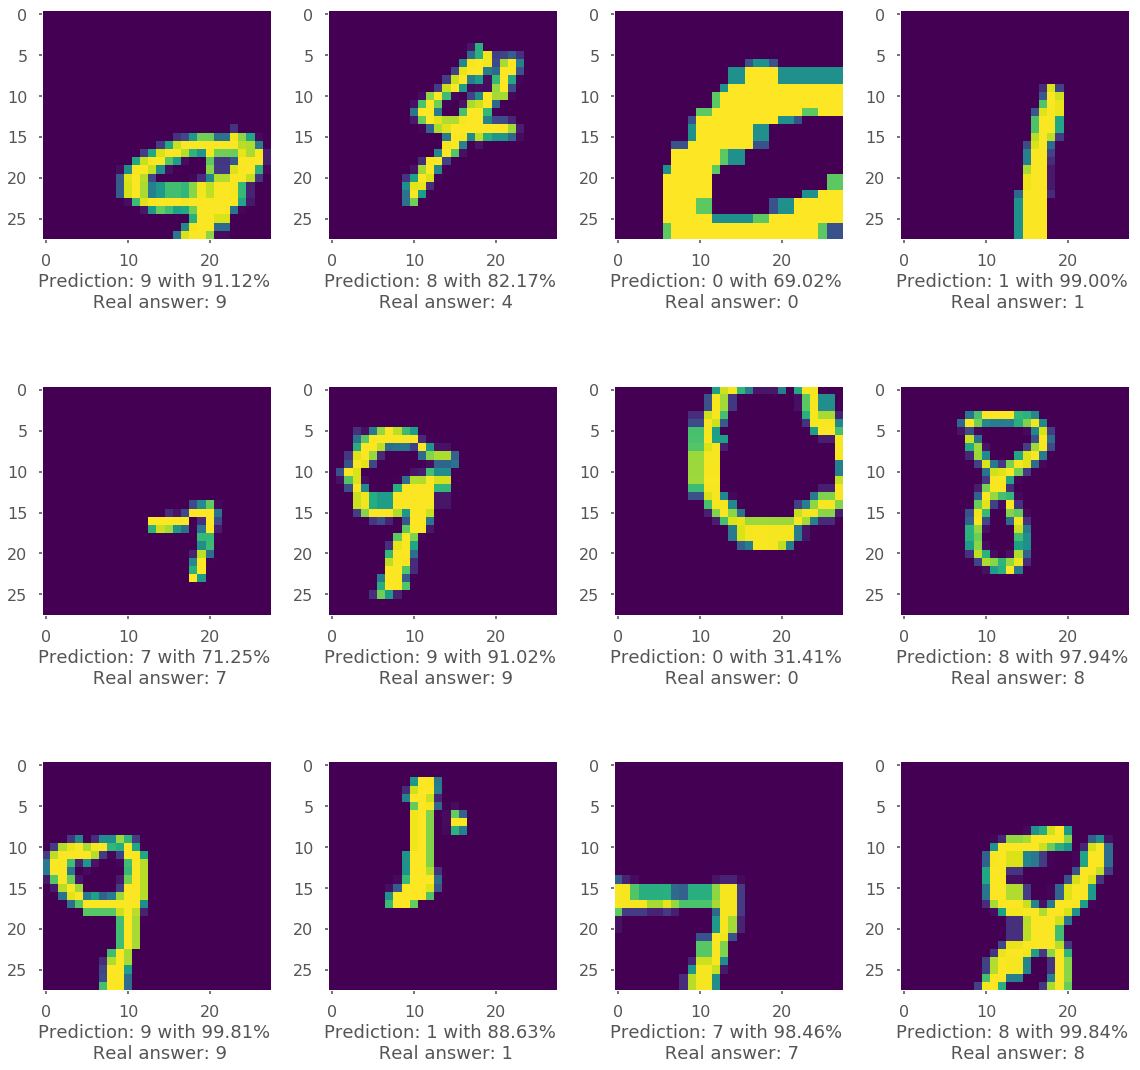

In [12]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for item in range(12):
    test_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= test_pipeline.get_variable('answers')
    img = test_pipeline.get_variable('img')
    predict = test_pipeline.get_variable('predict')
    proba = test_pipeline.get_variable('proba')
    ax[item].imshow(img[-1].reshape(-1, 28))
    ax[item].set_xlabel('Prediction: {} with {:.2f}% \n Real answer: {}'.format(
                             predict[-1],
                             proba[-1][np.argmax(proba[-1])] * 100,
                             answer[-1]),
                             fontsize=18)
    ax[item].grid()
plt.tight_layout(pad=0.4, w_pad=0., h_pad=1.0)
plt.show()

## Conclusion

Today you have learnt how to:
* create convolutional neural network with the Dataset.
* easily load MNIST data without writing your own loading functions.
* perforn data augmentation with dataset.
* configure the model using model config.

And found out that network can be more robust with data augmentations (like scale and rotate). 

## And what's next?
Because now you know how to work with convolutional models, you can:
* create a more sophisticated model
* change our model's config.

Your goal is 0.95 on the test data!

Good luck!

See [image augmentation tutorial](./06_image_augmentation.ipynb) for advanced augmentation methods or return to the [table of contents](./00_content.ipynb).